In [14]:
# import libraries 
import sys
from pathlib import Path
import joblib
import shap
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.sparse import issparse
from sklearn.base import clone
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.feature_selection import (SelectFromModel, SelectKBest,
                                       RFECV, RFE, mutual_info_classif,
                                       mutual_info_regression)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_curve, auc,
                             accuracy_score, confusion_matrix, explained_variance_score,
                             f1_score, mean_absolute_error, mean_squared_error, precision_recall_fscore_support,
                             precision_score, r2_score, recall_score, silhouette_score)
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer, LabelEncoder, OrdinalEncoder)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from umap import UMAP
from xgboost import XGBClassifier
from tempfile import gettempdir
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import matthews_corrcoef

# Add project root to the Python path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Import the project configuration settings
import config
from config import RANDOM_SEED
from utils import DataPreprocessingPipeline


In [4]:
# Load the raw data from the data/raw directory using the load_data method from the config module located at config.org
emergency_df = config.load_data('nhamcs14.sas7bdat', 'raw')

# Create a binary column where 2.0 in 'STAY24' is mapped to 1 mean ED discharge greater than 24 hours, and else 3.0 is mapped to 0.
emergency_df['STAY24'] = emergency_df['STAY24'].apply(lambda x: 1 if x == 2.0 else 0)

# Define the target variable and columns to drop
target = 'LOV_BINARY'
target_to_drop = ["LOV", 'WAITTIME_BINARY']

# Initializing the data preprocessing pipeline
pipeline = DataPreprocessingPipeline(
    emergency_df=emergency_df, target=target, target_to_drop=target_to_drop,
    percent_train=0.70, percent_val=0.15, percent_test=0.15, stratify=False
)

# Running the data preprocessing steps
pipeline.run()

# Extracting the preprocessed training, validation, and test sets
X_train_preprocessed = pipeline.X_train_preprocessed
X_validation_preprocessed = pipeline.X_validation_preprocessed
X_test_preprocessed = pipeline.X_test_preprocessed
y_train = pipeline.y_train
y_validation = pipeline.y_validation
y_test = pipeline.y_test

feature_names = pipeline.feature_names

cleaned_emergency_df = pipeline.cleaned_emergency_df
transformed_emergency_df = pipeline.transformed_emergency_df

# Save the feature names for future reference
feature_names = [name.replace('num__', '').replace('cat__', '') for name in pipeline.feature_names]
feature_names_list = list(feature_names)
config.save_data(feature_names, f"features_{target}.csv", 'features')

1-Cleaning data...
Data cleaning completed
Size of Initial dataset:(23844, 1012)
Size of cleaned dataset:(23844, 370)

2-Applying feature engineering...
Feature engineering completed
Size of the dataset after feature engineering:(23844, 386)

3-Splitting data...
self.stratify: False
Splitting data completed

4-Loading data...
train_df size: (16690, 386)
X_train size: (16690, 385)
y_train size: (16690,)

validation_df size: (3576, 386)
X_validation size: (3576, 385)
y_validation size: (3576,)

test_df size: (3578, 386)
X_test size: (3578, 385)
y_test size: (3578,)
Loading data completed

5-Preprocessing data...
Preprocessing data completed.
Processor saved successfully


In [9]:
# Cell 3: Model Training and Selection
def train_and_select_model(X_train, y_train, models_params, scoring_metrics, cv):
    model_scores = {}

    for model_name, mp in models_params.items():
        print(f"Evaluating model: {model_name}")

        if model_name in ['XGBClassifier', 'LGBMClassifier']:
            pipeline = ImbPipeline([
                ('smote', SMOTE(random_state=RANDOM_SEED)),
                ('classifier', mp['model'])
            ])
        else:
            pipeline = Pipeline([
                ('classifier', mp['model'])
            ])

        scores = cross_validate(pipeline, X_train, y_train, scoring=scoring_metrics, cv=cv, n_jobs=-1, return_train_score=False)
        mean_scores = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring_metrics}
        model_scores[model_name] = mean_scores
        print(f"Model: {model_name} - Scores: {mean_scores}")

    best_model_name = max(model_scores, key=lambda k: (
        model_scores[k]['f1_weighted'],
        model_scores[k]['roc_auc'],
        model_scores[k]['precision'],
        model_scores[k]['recall']
    ))
    print(f"Best model based on comprehensive evaluation: {best_model_name}")

    best_pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_SEED)),
        ('classifier', models_params[best_model_name]['model'])
    ]) if best_model_name in ['XGBClassifier', 'LGBMClassifier'] else Pipeline([
        ('classifier', models_params[best_model_name]['model'])
    ])

    best_pipeline.fit(X_train, y_train)

    model_filename = f"{best_model_name}_best_model"
    directory = "/Users/Macbook/Desktop/EDPredictiveEfficiency/notebooks/model_train"
    os.makedirs(directory, exist_ok=True)
    joblib.dump(best_model_name, os.path.join(directory, f"{model_filename}.joblib"))
    print(f"Saved {best_model_name} model to {directory}")

    return best_model_name, best_pipeline

# Define the model and parameters for RandomizedSearchCV
models_params = {
    'LGBMClassifier': {
        'model': LGBMClassifier(is_unbalance=True, verbose=-1),
        'params': {
            'classifier__max_depth': [3, 4, 5],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__n_estimators': [100, 200]
        }
    },
    'CatBoostClassifier': {
        'model': CatBoostClassifier(verbose=0),
        'params': {
            'classifier__depth': [3, 4, 5],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__iterations': [100, 200],
            'classifier__train_dir': [gettempdir()]
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__n_estimators': [100, 500],
            'classifier__subsample': [0.6, 0.8],
            'classifier__colsample_bytree': [0.6, 0.8]
        }
    },
    'Random Forest Classifier': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None]
        }
    },
    'Gradient Boosting Classifier': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    'XGBClassifier (Updated)': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'classifier__max_depth': [3, 4, 5],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__n_estimators': [100, 200]
        }
    },
    'MLPClassifier': {
        'model': MLPClassifier(max_iter=100),
        'params': {
            'classifier__alpha': [0.0001, 0.001, 0.01],
            'classifier__hidden_layer_sizes': [(100,), (50, 50), (100, 50)]
        }
    }
}

# Define scoring metrics
scoring_metrics = {
    'f1_weighted': 'f1_weighted',
    'roc_auc': 'roc_auc',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted'
}

# Initialize Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Train and select the best model
best_model_name, best_pipeline = train_and_select_model(X_train_preprocessed, y_train, models_params, scoring_metrics, cv)


Evaluating model: LGBMClassifier


Model: LGBMClassifier - Scores: {'f1_weighted': 0.8178768976397283, 'roc_auc': 0.8720626003196055, 'precision': 0.8164048109120747, 'recall': 0.8240263630916717}
Evaluating model: CatBoostClassifier
Model: CatBoostClassifier - Scores: {'f1_weighted': 0.8220718977705053, 'roc_auc': 0.8776154442842369, 'precision': 0.8225961109969193, 'recall': 0.830557219892151}
Evaluating model: RandomForestClassifier
Model: RandomForestClassifier - Scores: {'f1_weighted': 0.7984327400792653, 'roc_auc': 0.8613318120693636, 'precision': 0.8025783988205891, 'recall': 0.8132414619532655}
Evaluating model: XGBClassifier
Model: XGBClassifier - Scores: {'f1_weighted': 0.8138065706071504, 'roc_auc': 0.8620045644614075, 'precision': 0.811901018299511, 'recall': 0.8194128220491311}
Evaluating model: Random Forest Classifier
Model: Random Forest Classifier - Scores: {'f1_weighted': 0.7975493872227499, 'roc_auc': 0.8610950350151473, 'precision': 0.8022022028400466, 'recall': 0.8128819652486519}
Evaluating model: 

/Users/Macbook/Library/Caches/pypoetry/virtualenvs/edpredictiveefficiency-6OWGp70p-py3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: MLPClassifier - Scores: {'f1_weighted': 0.7889355164855647, 'roc_auc': 0.8147615699301218, 'precision': 0.7869305552889219, 'recall': 0.7916716596764528}
Best model based on comprehensive evaluation: CatBoostClassifier
Saved CatBoostClassifier model to /Users/Macbook/Desktop/EDPredictiveEfficiency/notebooks/model_train


In [10]:
# Cell 4: Hyperparameter Tuning
# Load the saved best model
model_train_dir = "/Users/Macbook/Desktop/EDPredictiveEfficiency/notebooks/model_train/"
model_filename = "CatBoostClassifier_best_model.joblib"
model_file_path = os.path.join(model_train_dir, model_filename)
trained_model_classification = joblib.load(model_file_path) if os.path.exists(model_file_path) else print(f"No such file found: {model_file_path}")

# Define a range of hyperparameters for CatBoostClassifier
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 300, 400],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize CatBoostClassifier with auto_class_weights set to 'Balanced'
catboost_model = CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced')

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring=make_scorer(f1_score, average='weighted'),
    verbose=1
)

# Perform hyperparameter tuning
print("Starting hyperparameter tuning...")
grid_search.fit(X_train_preprocessed, y_train)

# Retrieve and report the best hyperparameters
best_hyperparams = grid_search.best_params_
print(f"Best hyperparameters: {best_hyperparams}")

# Training the final model with best hyperparameters
best_model = grid_search.best_estimator_

# Evaluate on validation set
y_validation_pred = best_model.predict(X_validation_preprocessed)
y_validation_proba = best_model.predict_proba(X_validation_preprocessed)[:, 1]

# Calculate metrics
f1_validation = f1_score(y_validation, y_validation_pred, average='weighted')
roc_auc_validation = roc_auc_score(y_validation, y_validation_proba)
precision_validation = precision_score(y_validation, y_validation_pred, average='weighted')
recall_validation = recall_score(y_validation, y_validation_pred, average='weighted')

print(f"Validation Metrics:\nF1 (Weighted): {f1_validation:.2f}, ROC AUC: {roc_auc_validation:.2f}, Precision (Weighted): {precision_validation:.2f}, Recall (Weighted): {recall_validation:.2f}")

# Metrics for each class
report = classification_report(y_validation, y_validation_pred, output_dict=True)
print(classification_report(y_validation, y_validation_pred))

for label, metrics in report.items():
    if label not in ('accuracy', 'macro avg', 'weighted avg'):
        print(f"Class {label} - Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-score: {metrics['f1-score']:.2f}")

path_models = "/Users/Macbook/Desktop/EDPredictiveEfficiency/notebooks/model_train"
model_filename = f"{path_models}/best_lov_classification_catboost_model.joblib"
joblib.dump(best_model, model_filename)
print("best_lov_classification_catboost_model saved")

Starting hyperparameter tuning...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters: {'depth': 8, 'iterations': 400, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
Validation Metrics:
F1 (Weighted): 0.83, ROC AUC: 0.88, Precision (Weighted): 0.83, Recall (Weighted): 0.82
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88      2686
         1.0       0.63      0.70      0.66       890

    accuracy                           0.82      3576
   macro avg       0.76      0.78      0.77      3576
weighted avg       0.83      0.82      0.83      3576

Class 0.0 - Precision: 0.90, Recall: 0.86, F1-score: 0.88
Class 1.0 - Precision: 0.63, Recall: 0.70, F1-score: 0.66
best_lov_classification_catboost_model saved


In [11]:
class ModelEvaluator:
    def __init__(self, model, X, y, feature_names):
        self.model = model
        self.X = X 
        self.y = y
        self.feature_names = feature_names   
    def evaluate_model(self, X_test, y_test):
            y_pred = self.model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            if hasattr(self.model, 'predict_proba'):
                y_pred_prob = self.model.predict_proba(X_test)[:, 1]
                auc_roc = roc_auc_score(y_test, y_pred_prob)
            else:
                auc_roc = None
            return pd.DataFrame({
                'Accuracy': [accuracy],
                'Precision': [precision],
                'Recall': [recall],
                'F1-score': [f1],
                'AUC-ROC': [auc_roc]
            })

    def plot_roc_curve(self, X_test, y_test):
            if hasattr(self.model, 'predict_proba'):
                y_pred_prob = self.model.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
                plt.plot(fpr, tpr, label=f'{self.model.__class__.__name__} (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')

            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend()
            plt.show()

    def plot_precision_recall_curve(self, X_test, y_test):
            if hasattr(self.model, 'predict_proba'):
                y_pred_prob = self.model.predict_proba(X_test)[:, 1]
                precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
                plt.plot(recall, precision, label=f'{self.model.__class__.__name__} (AP = {np.trapz(precision, recall):.2f})')

            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.legend()
            plt.show()

    def plot_confusion_matrix(self, X_test, y_test):
            y_pred = self.model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
            plt.title(f'Confusion Matrix for {self.model.__class__.__name__}')
            plt.show()
            
    def plot_feature_importance(self, best_model, top_n=10):
            if isinstance(best_model, CatBoostClassifier):
                feature_importance_df = pd.DataFrame({
                    'Feature': self.feature_names,
                    'Importance': best_model.feature_importances_
                }).sort_values(by='Importance', ascending=False)

                plt.figure(figsize=(10, 6))
                plt.title(f'Top {top_n} Feature Importances')
                sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), color='skyblue')
                plt.xlabel('Importance')
                plt.ylabel('Features')
                plt.tight_layout()
                plt.show()

In [12]:
def main():
    # Load the best model (CatBoostClassifier) from the models file
    best_model = joblib.load('/Users/Macbook/Desktop/EDPredictiveEfficiency/notebooks/model_train/best_lov_classification_catboost_model.joblib')

    # Create an instance of the ModelEvaluator with the loaded model
    evaluator = ModelEvaluator(best_model, X_test_preprocessed, y_test, feature_names)

    # Evaluate the model
    results = evaluator.evaluate_model(X_test_preprocessed, y_test)
    print("Model Evaluation Results:")
    print(results)

    # Plot ROC curve
    print("Plotting ROC Curve...")
    evaluator.plot_roc_curve(X_test_preprocessed, y_test)

    # Plot Precision-Recall curve
    print("Plotting Precision-Recall Curve...")
    evaluator.plot_precision_recall_curve(X_test_preprocessed, y_test)

    # Plot confusion matrix
    print("Plotting Confusion Matrix...")
    evaluator.plot_confusion_matrix(X_test_preprocessed, y_test)

    # Plot Feature Importances
    print("Plotting Feature Importances...")
    evaluator.plot_feature_importance(best_model, top_n=10)


Model Evaluation Results:
   Accuracy  Precision   Recall  F1-score   AUC-ROC
0   0.81526   0.619941  0.69469   0.65519  0.869326
Plotting ROC Curve...


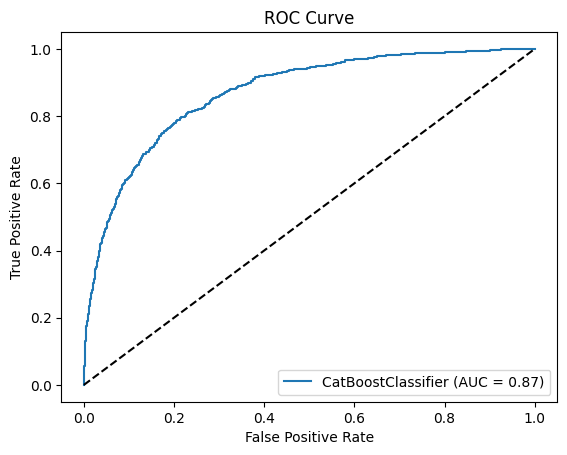

Plotting Precision-Recall Curve...


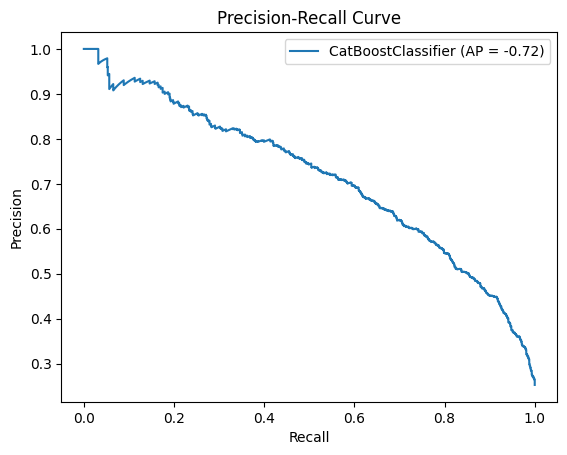

Plotting Confusion Matrix...


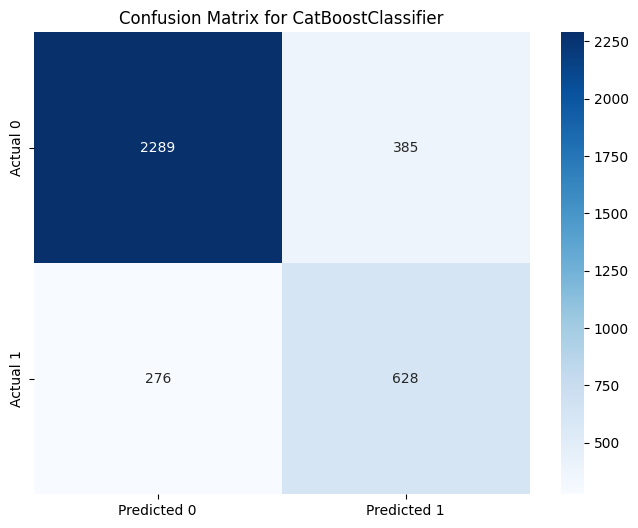

Plotting Feature Importances...


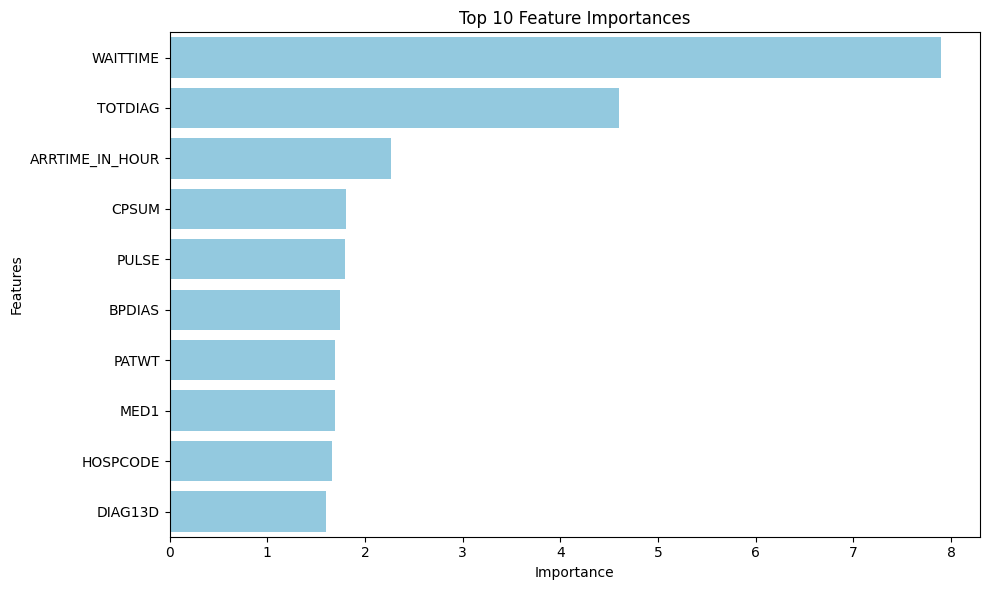

In [13]:
if __name__ == "__main__":
    main()